In [1]:
import time
ini=time.time()

year_testing=10

import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
comex_df=pd.read_csv('/home/andre301267/git/Pricing-Fertilizer/DB/temp/imp_fert_ncm_quanti.csv')

In [2]:
comex_df['date']=pd.to_datetime(comex_df.year.astype(str)+'-'+comex_df.month.astype(str)+'-01')
comex_df=comex_df[comex_df.date<=comex_df.date.max()-DateOffset(months=11)]
comex_df=comex_df.drop(columns='date')

In [3]:
comex_df.columns

Index(['year', 'month', 'ncm', 'Product', 'UF', 'pais', 'urf', 'kg', 'US$_fob',
       'US$_freight', 'US$_insurance', 'cif_kg', 'fob_kg', 'km', 'preço'],
      dtype='object')

In [4]:
prdt_lonely=['MOP']
uf_lonely=['BA']
month_lonely=[comex_df[comex_df.year==comex_df.year.max()].month.max()]


prdt_conj=['MOP','MAP']
uf_conj=['BA','TO','GO']
month_conj=[3,4,5,6,7,8,9]

In [5]:
dict={'lonely':[prdt_lonely,uf_lonely, month_lonely],'conj':[prdt_conj,uf_conj,month_conj]}
hip_list = ['lonely','conj']

In [6]:
qq=pd.DataFrame()

for f in hip_list:

    h=dict[f]

    # Filtra Product, UF and month
    comex_df_t1=comex_df[
    (comex_df.Product.isin(h[0]))&
    (comex_df.UF.isin(h[1]))&
    (comex_df.month.isin(h[2]))]
    
    # filtra km deixando passar o maior km de cada produto
    filtra_km=comex_df_t1[['Product','km']].drop_duplicates().sort_values(by=['Product','km'],ascending=False)\
        .drop_duplicates(subset='Product')
    comex_df_t1=comex_df_t1.merge(filtra_km)
    
    # Save real begins and ends
    comex_df_t1['date']=pd.to_datetime(comex_df_t1.year.astype(str)+'-'+comex_df_t1.month.astype(str)+'-01')
    date_min=comex_df_t1.date.min()
    date_max=comex_df_t1.date.max()
    
    # Calendar full
    years=pd.DataFrame({'year':np.arange(comex_df_t1.year.min(),
                                         comex_df_t1.year.max()+1)}).assign(key=0)
    months=pd.DataFrame({'month':np.arange(1,13)}).assign(key=0)
    calendar=years.merge(months,on='key')
    calendar_full=comex_df_t1[['Product','UF']].drop_duplicates().assign(key=0).merge(calendar,on='key').drop('key',axis=1)
    
    # Merge calendar full
    comex_df_t1=comex_df_t1.merge(calendar_full)
    
    # Saprse Matrix
    comex_df_t1[['month','Product','UF']]=comex_df_t1[['month', 'Product','UF']].astype('category')
    comex_df_t1=comex_df_t1.groupby(by=['year','month','Product','UF'],observed=False).kg.sum().reset_index()
    
    # Prune
    comex_df_t1['date']=pd.to_datetime(comex_df_t1.year.astype(str)+'-'+comex_df_t1.month.astype(str)+'-01')
    comex_df_t1=comex_df_t1[(comex_df_t1.date>=date_min)&(comex_df_t1.date<=date_max)]

    # Excl 2020(covid)
    #comex_df_t1=comex_df_t1[comex_df_t1.year!=2020]


    
    # Dummies
    comex_df_t1=pd.get_dummies(comex_df_t1,prefix_sep='~')

    # Classify
    
    comex_df_t1=comex_df_t1.assign(oc=0)
    comex_df_t1.loc[comex_df_t1.kg>0,'oc']=1
    
    comex_df_t2=comex_df_t1.copy()
    for r in range(1,year_testing+1):
        
        
        # Classifying
        train=comex_df_t2[comex_df_t2.date<comex_df_t2.date.max()]
        test=comex_df_t2[comex_df_t2.date==comex_df_t2.date.max()]
        X_train=train.drop(['kg','oc','date'],axis=1)
        print('X_train',X_train.columns)
        y_train=train.oc
        X_test=test.drop(['kg','oc','date'],axis=1)
        y_test=test.oc
        from sklearn.ensemble import RandomForestClassifier as rfc
        model=rfc()
        model.fit(X_train,y_train)
        test['y_pred']=model.predict(X_test)
        
        if r==1:
            results=test
        else:
            results=pd.concat([results,test])
        
        comex_df_t2=comex_df_t2[comex_df_t2.date<=comex_df_t2.date.max()-DateOffset(years=1)]
    

    # Regression
    
    comex_df_t1=results.merge(comex_df_t1,how='outer')
    
    comex_df_t1=comex_df_t1[(comex_df_t1.oc==1)&(comex_df_t1.y_pred.isin([1,np.nan]))].drop(columns='y_pred')
    
    comex_df_t2=comex_df_t1.copy()
    features_df=pd.DataFrame()
    for r in range(1,year_testing+1):
        train=comex_df_t2[comex_df_t2.date<comex_df_t2.date.max()]
        test=comex_df_t2[comex_df_t2.date==comex_df_t2.date.max()]
        
        X_train=train.drop(['kg','oc','date'],axis=1)
        y_train=train.kg
        
        X_test=test.drop(['kg','oc','date'],axis=1)
        y_test=test.kg
        
        from sklearn.ensemble import RandomForestRegressor as rfr

        
        model=rfr(max_depth=8,max_features=8)


        model.fit(X_train,y_train)
        test['y_pred']=y_pred=model.predict(X_test)
        
        # features importances
        t=pd.DataFrame({'names':model.feature_names_in_,'importances':model.feature_importances_})
        features_df=pd.concat([features_df,t])
        
        if r==1:
            results=test
        else:
            results=pd.concat([results,test])

        qq=pd.concat([qq,results.assign(f=f)])
        
        comex_df_t2=comex_df_t2[comex_df_t2.date<=comex_df_t2.date.max()-DateOffset(years=1)]
    
    print('\n',f)
    
    display(features_df.groupby('names').importances.mean().reset_index()\
            .sort_values(by='importances',ascending=False))

    # Back from dummies
    o=results[results.columns[~results.columns.str.contains('~')]]    
    prdt=pd.from_dummies(results[results.columns[results.columns.str.contains('Product')]],sep='~')    
    month=pd.from_dummies(results[results.columns[results.columns.str.contains('month')]],sep='~')    
    uf=pd.from_dummies(results[results.columns[results.columns.str.contains('UF')]],sep='~')    
    results=pd.concat([o,prdt,month,uf],axis=1)

    # Filtering
    mes=results.month.unique()[0]    
    results=results[(results.Product=='MOP')&(results.month==mes)&(results.UF=='BA')]

    # Metrics
    from sklearn.metrics import root_mean_squared_error as rse
    results['rse']=rse(results.kg,results.y_pred)    
    from sklearn.metrics import mean_absolute_percentage_error as mape
    results['mape']=rse(results.kg,results.y_pred)
    print(f"\nPara {f} - rse={int(results.rse.unique()/10**6)} Kton")
    print(f"\nPara {f} - mape={int(results.mape.unique())} %")
    

end=time.time()
print(f"Duração: {round((end-ini)/60,1)} minutos.")

X_train Index(['year', 'month~9', 'Product~MOP', 'UF~BA'], dtype='object')
X_train Index(['year', 'month~9', 'Product~MOP', 'UF~BA'], dtype='object')
X_train Index(['year', 'month~9', 'Product~MOP', 'UF~BA'], dtype='object')
X_train Index(['year', 'month~9', 'Product~MOP', 'UF~BA'], dtype='object')
X_train Index(['year', 'month~9', 'Product~MOP', 'UF~BA'], dtype='object')
X_train Index(['year', 'month~9', 'Product~MOP', 'UF~BA'], dtype='object')
X_train Index(['year', 'month~9', 'Product~MOP', 'UF~BA'], dtype='object')
X_train Index(['year', 'month~9', 'Product~MOP', 'UF~BA'], dtype='object')
X_train Index(['year', 'month~9', 'Product~MOP', 'UF~BA'], dtype='object')
X_train Index(['year', 'month~9', 'Product~MOP', 'UF~BA'], dtype='object')

 lonely


,names,importances
3,year,1.0
0,Product~MOP,0.0
1,UF~BA,0.0
2,month~9,0.0



Para lonely - rse=39 Kton

Para lonely - mape=39001667 %
X_train Index(['year', 'month~3', 'month~4', 'month~5', 'month~6', 'month~7',
       'month~8', 'month~9', 'Product~MAP', 'Product~MOP', 'UF~BA', 'UF~GO',
       'UF~TO'],
      dtype='object')
X_train Index(['year', 'month~3', 'month~4', 'month~5', 'month~6', 'month~7',
       'month~8', 'month~9', 'Product~MAP', 'Product~MOP', 'UF~BA', 'UF~GO',
       'UF~TO'],
      dtype='object')
X_train Index(['year', 'month~3', 'month~4', 'month~5', 'month~6', 'month~7',
       'month~8', 'month~9', 'Product~MAP', 'Product~MOP', 'UF~BA', 'UF~GO',
       'UF~TO'],
      dtype='object')
X_train Index(['year', 'month~3', 'month~4', 'month~5', 'month~6', 'month~7',
       'month~8', 'month~9', 'Product~MAP', 'Product~MOP', 'UF~BA', 'UF~GO',
       'UF~TO'],
      dtype='object')
X_train Index(['year', 'month~3', 'month~4', 'month~5', 'month~6', 'month~7',
       'month~8', 'month~9', 'Product~MAP', 'Product~MOP', 'UF~BA', 'UF~GO',
       'UF~

,names,importances
12,year,0.403126
1,Product~MOP,0.108568
0,Product~MAP,0.104218
3,UF~GO,0.077909
4,UF~TO,0.063970
6,month~4,0.037467
2,UF~BA,0.035037
10,month~8,0.031159
5,month~3,0.029990
7,month~5,0.029614



Para conj - rse=28 Kton

Para conj - mape=28893752 %
Duração: 0.2 minutos.


In [7]:
qq_f=qq[(qq['Product~MOP']==1)&(qq['UF~BA']==1)]

In [8]:
qq_l=pd.concat([
    qq_f[qq_f.f=='conj'][['year','kg']].assign(tipo='real'),
    qq_f[qq_f.f=='lonely'][['year','y_pred']].assign(tipo='pred_lonely').rename(columns={'y_pred':'kg'}),
    qq_f[qq_f.f=='conj'][['year','y_pred']].assign(tipo='pred_conj').rename(columns={'y_pred':'kg'}),
])

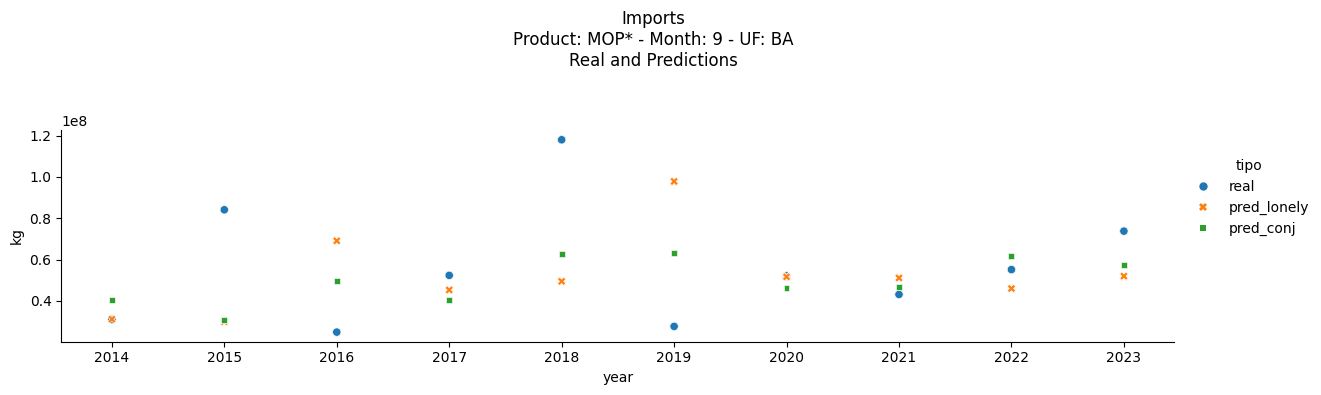

In [9]:
g=sns.relplot(data=qq_l,x='year',y='kg',hue='tipo',height=3,aspect=4, style='tipo')
#g.set(ylim=(3*10**7, None))
g.fig.suptitle(f"Imports\nProduct: MOP* - Month: {mes} - UF: BA\nReal and Predictions",y=1.3)
plt.xticks(ticks=qq_l.year.unique())
plt.show()

In [10]:
end=time.time()
print(f"Duração: {round((end-ini)/60,1)} minutos.")

Duração: 0.2 minutos.
